In [1]:
import ccdproc
import os
import datetime

from astropy import units as u

from multiprocessing import cpu_count, Lock

def getMkdir(dirPath: str) -> str:
	if not os.path.exists(dirPath):
		os.mkdir(dirPath)
	return dirPath

LOGGING_LOCK = Lock()
def printToLog(msg: str):
	with LOGGING_LOCK:
		with open(os.path.join(BASE_DATA_DIR, f"{OBSV_DATE}.log"), "a+") as logFile:
			logFile.write(f"[{datetime.datetime.now()}] {msg}\n")

MAX_PARALLEL = cpu_count() - 2

OBSV_DATE = datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d")
BASE_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"

BIAS_DIR =  os.path.join(BASE_DATA_DIR, "Bias", OBSV_DATE)
DARKS_DIR = os.path.join(BASE_DATA_DIR, "Darks", OBSV_DATE)
FLATS_DIR = os.path.join(BASE_DATA_DIR, "Flats", OBSV_DATE)

DATA_DIR = [os.path.join(BASE_DATA_DIR, d) for d in os.listdir(BASE_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(BASE_DATA_DIR, d))][0]
CCD_KWARGS = {'unit': 'adu'}
DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06'

In [ ]:
# Master Bias

biasImages = ccdproc.ImageFileCollection(BIAS_DIR)
print("Using bias images:", biasImages.files)
masterBias = ccdproc.Combiner(biasImages.ccds(ccd_kwargs=CCD_KWARGS)).median_combine()

biasOutDir = getMkdir(os.path.join(BIAS_DIR, "out"))
biasFilePath = os.path.join(biasOutDir, f"{OBSV_DATE}_MasterBias.fits")
masterBias.write(biasFilePath, overwrite=True)

In [ ]:
# Master Dark

rawDarks = ccdproc.ImageFileCollection(DARKS_DIR)
print("Using dark images:", rawDarks.files)
biasCorrectedDir = getMkdir(os.path.join(DARKS_DIR, "bias_corrected"))

exposureTime: None
for dark, dark_fname in rawDarks.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	correctedDark = ccdproc.subtract_bias(dark, masterBias)
	exposureTime = correctedDark.header['EXPOSURE']
	correctedDark.write(os.path.join(biasCorrectedDir, f"b_{dark_fname}"), overwrite=True)

b_darks = ccdproc.ImageFileCollection(biasCorrectedDir)
masterDark = ccdproc.Combiner(b_darks.ccds(ccd_kwargs=CCD_KWARGS)).median_combine()
masterDark.header['EXPOSURE'] = exposureTime

darkOutDir = getMkdir(os.path.join(DARKS_DIR, "out"))
masterDarkFilePath = os.path.join(darkOutDir, f"{OBSV_DATE}_MasterDark.fits")
masterDark.write(masterDarkFilePath, overwrite=True)

In [ ]:
# Master flat

rawFlats = ccdproc.ImageFileCollection(FLATS_DIR)
print("Using flat images:", rawFlats.files)
correctedFlatsDir = getMkdir(os.path.join(FLATS_DIR, "corrected"))

for flat, flat_fname in rawFlats.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	b_flat = ccdproc.subtract_bias(flat, masterBias)
	bd_flat = ccdproc.subtract_dark(b_flat, masterDark, exposure_time='EXPOSURE', exposure_unit=u.second, scale=True)
	bd_flat.write(os.path.join(correctedFlatsDir, f"bd_{flat_fname}"), overwrite=True)

bd_flats = ccdproc.ImageFileCollection(correctedFlatsDir)
masterFlat = ccdproc.Combiner(bd_flats.ccds(ccd_kwargs=CCD_KWARGS)).median_combine()

flatOutDir = getMkdir(os.path.join(FLATS_DIR, "out"))
masterFlatFilePath = os.path.join(flatOutDir, f"{OBSV_DATE}_MasterFlat.fits")
masterFlat.write(masterFlatFilePath, overwrite=True)

In [ ]:
# Bias, Dark, Flat image correction

correctedDir = getMkdir(os.path.join(DATA_DIR, "corrected"))

rawImages = ccdproc.ImageFileCollection(DATA_DIR)
for img, img_fname in rawImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	b_img = ccdproc.subtract_bias(img, masterBias)
	bd_img = ccdproc.subtract_dark(b_img, masterDark, exposure_time='EXPOSURE', exposure_unit=u.second, scale=True)
	bdf_img = ccdproc.flat_correct(bd_img, masterFlat)
	bdf_img.write(os.path.join(correctedDir, f"bdf_{img_fname}"), overwrite=True)

In [ ]:
# Plate solving

import subprocess
import datetime
import numpy as np

from multiprocessing import Pool

SOLVE_CMD_TEMPLATE = "solve-field --fits-image --no-plots --timestamp --new-fits {solvedOutPath} --cpulimit 180 -D {tempFiles} {inputPath} --overwrite"
		
def plateSolveFile(correctedFile: str, correctedDir: str):
	solvedFitsDir = getMkdir(os.path.join(correctedDir, "solved-fits"))
	plateSolveCmd = SOLVE_CMD_TEMPLATE.format(inputPath=os.path.join(correctedDir, correctedFile), 
											solvedOutPath=os.path.join(solvedFitsDir, correctedFile),
											tempFiles=os.path.join(correctedDir, "solved"))
	print(plateSolveCmd)
	result = subprocess.run(plateSolveCmd, shell=True)
	if result.returncode != 0:
		printToLog(f"Failed to plate solve {correctedFile}")

def plateSolve(correctedFiles: list[str], correctedDir: str):
	# print(f"{os.getpid()} {correctedFiles[0]} {len(correctedFiles)}\n")
	printToLog(f"[{os.getpid()}] Begin plate solving")
	for cFile in correctedFiles:
		plateSolveFile(cFile, correctedDir)
	printToLog(f"[{os.getpid()}] Finished plate solving")

class SolveCaller:
	def __init__(self, correctedDir: str) -> None:
		self.correctedDir = correctedDir

	def __call__(self, imagesChunks):
		plateSolve(imagesChunks, self.correctedDir)

correctedDir = os.path.join(DATA_DIR, "corrected") # output files from previous cell
imagesChunks = np.array_split(os.listdir(correctedDir), MAX_PARALLEL)
with Pool(MAX_PARALLEL) as pool:
	pool.map(SolveCaller(correctedDir), imagesChunks)

In [ ]:
# Shift plate solved images

from ccdproc import wcs_project
from astropy.wcs import WCS

from astropy.io import fits

targetWcs: WCS = None
correctedDir = os.path.join(DATA_DIR, "corrected")
solvedFitsDir = os.path.join(correctedDir, "solved-fits")
shiftedDir = getMkdir(os.path.join(correctedDir, "shifted"))

rawImages = ccdproc.ImageFileCollection(solvedFitsDir)
for img, img_fname in rawImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	if not targetWcs:
		targetWcs = WCS(img.header)
		with fits.open(os.path.join(solvedFitsDir, img_fname)) as fitsImg:
			targetWcs = WCS(fitsImg.pop())
		img.write(os.path.join(shiftedDir, f"s_{img_fname}"), overwrite=True)
	else:
		shiftedImg = wcs_project(img, targetWcs)
		shiftedImg.write(os.path.join(shiftedDir, f"s_{img_fname}"), overwrite=True)

In [3]:
# Aperture photometry

from photutils.aperture import SkyCircularAperture, aperture_photometry
from astropy.coordinates import SkyCoord, ICRS
from astropy.wcs import WCS

DATE_OBSV_FIELD = "DATE-OBS"

shiftedDir = os.path.join(DATA_DIR, "corrected", "shifted")
shiftedImages = ccdproc.ImageFileCollection(shiftedDir)

aperture = SkyCircularAperture(SkyCoord(339.94692562872, 45.14639621713, frame=ICRS, unit=u.deg), r=0.28 * u.arcsec)
starFlux: None
for img, img_fname in shiftedImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	starFlux = aperture_photometry(img, aperture)
	dateObsv = img.header[DATE_OBSV_FIELD]
	break
starFlux

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",adu
int64,float64,float64,SkyCoord,float64
1,964.0507863470698,599.9750119988993,"339.94692562872,45.14639621713",2535.4137818093873


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
s_bdf_2022-12-06_19-13-29_0000.fits
      id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
90    91   964.207404   600.489704   0.620988   -0.524622   -0.275754    81   
147  148   970.387514  1066.523950   0.335248    0.112706   -0.370157    81   
8      9   986.283557    62.945764   0.526650   -0.586782   -0.437395    81   
83    84   940.844984   561.507511   0.525107   -0.635628   -0.590116    81   
92    93   933.337078   620.861248   0.517695   -0.387525   -0.160742    81   
..   ...          ...          ...        ...         ...         ...   ...   
1      2  1915.913316     3.119438   0.240086    0.210841    0.056529    81   
165  166  1915.951444  1195.928058   0.268543   -0.318431    0.015040    81   
119  120     8.712131   846.654514   0.386658   -0.526702   -0.425799    81   
0      1     3.170008     3.034136   0.309565   -0.26862

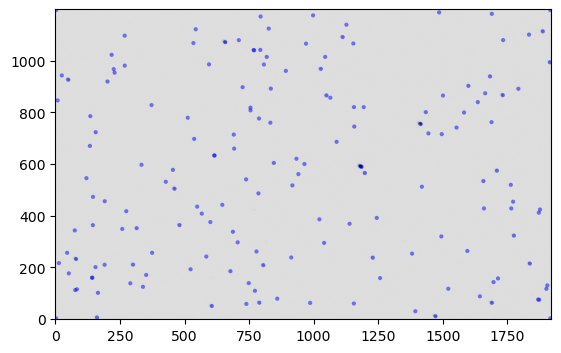

In [25]:
# Trying to extract magnitudes and flux a different way. NOT WORKING SO FAR

from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

shiftedDir = os.path.join(DATA_DIR, "corrected", "shifted")
shiftedImages = ccdproc.ImageFileCollection(shiftedDir)
for img, img_fname in shiftedImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	print(img_fname)
	data = img.data
	mean, median, std = sigma_clipped_stats(data, sigma=3.0)
	daofind = DAOStarFinder(fwhm=7.0, threshold=5.*std)

	sources = daofind(data)
	for col in sources.colnames:  
		sources[col].info.format = '%.8g'  # for consistent table output
	pandasSources = sources.to_pandas()
	pandasSources['xdist'] = abs(pandasSources['xcentroid'] - 964.0507863470698)
	pandasSources['ydist'] = abs(pandasSources['ycentroid'] - 599.9750119988993)
	print(pandasSources.sort_values('xdist'))
	print(pandasSources.loc[(pandasSources['xdist'] < 0.01)])
	# print(pandasSources.loc[(abs(pandasSources['xcentroid'] - 964.0507863470698) < 0.01) & (abs(pandasSources['ycentroid'] - 599.9750119988993) < 0.01)])

	positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
	apertures = CircularAperture(positions, r=4.0)
	norm = ImageNormalize(stretch=SqrtStretch())
	plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
	apertures.plot(color='blue', lw=1.5, alpha=0.5)
	break

============================= test session starts ==============================
platform linux -- Python 3.10.4, pytest-7.2.0, pluggy-1.0.0


        Use pytest.mark.filterwarnings instead. [pytest_astropy_header.display]
        Use pytest.warns instead. [astropy.tests.helper]



Running tests with photutils version 1.5.0.
Running tests in anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils.

Date: 2023-01-09T18:59:15

Platform: Linux-6.0.17-300.fc37.x86_64-x86_64-with-glibc2.36

Executable: /home/ramon/anaconda3/envs/mapta-tesis-310/bin/python

Full Python Version: 
3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]

encodings: sys: utf-8, locale: UTF-8, filesystem: utf-8
byteorder: little
float info: dig: 15, mant_dig: 15

Package versions: 
Numpy: 1.23.1
Scipy: 1.9.3
Matplotlib: 3.5.2
Cython: 0.29.32
Astropy: 5.1.1
scikit-image: 0.19.2
scikit-learn: 1.1.3

Using Astropy options: remote_data: none.

rootdir: /home/ramon
plugins: anyio-3.5.0, hypothesis-6.58.0, astropy-header-0.1.2, cov-4.0.0, doctestplus-0.12.1, filter-subpackage-0.1.1, mock-3.10.0, openfiles-0.5.0, remotedata-0.3.3, asdf-2.14.1, arraydiff-0.3, astropy-0.10.0
collected 1439 items

../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/aperture/te

EPSFBuilder (8 maxiters):   0%|          | 0/8 [00:00<?, ?it/s]

......                                                                  [ 79%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/psf/tests/test_epsf_stars.py . [ 79%]
...                                                                      [ 79%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/psf/tests/test_groupstars.py . [ 79%]
.............                                                            [ 80%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/psf/tests/test_models.py . [ 80%]
..........................                                               [ 82%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/psf/tests/test_photometry.py . [ 82%]
..xx.........................                                            [ 84%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/psf/tests/test_sandbox.py . 

  0%|          | 0/1 [00:00<?, ?it/s]

.                                          [ 93%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/segmentation/tests/test_detect.py . [ 93%]
...............................                                          [ 95%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/segmentation/tests/test_finder.py . [ 95%]
..                                                                       [ 96%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/segmentation/tests/test_utils.py . [ 96%]
......                                                                   [ 96%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/utils/tests/test_colormaps.py . [ 96%]
                                                                         [ 96%]
../../../../../anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/photutils/utils/tests/test_convolution.py . [ 96

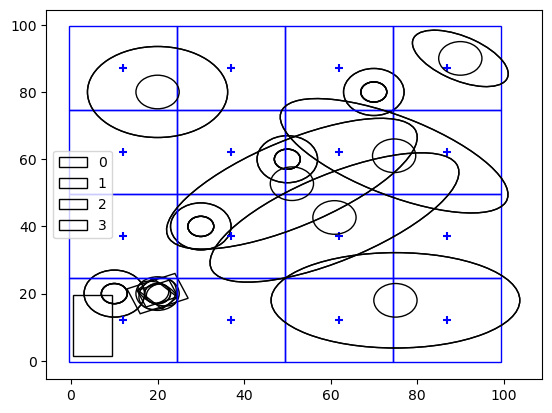

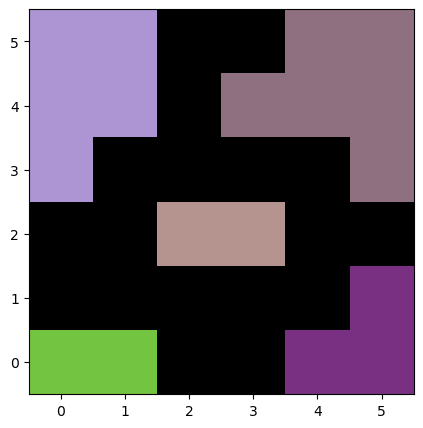

In [7]:
# Time series period analysis

from astropy.timeseries import TimeSeries
from astropy.io import fits

# Testing, should be gotten from previous cell
shiftedDir = os.path.join(DATA_DIR, "corrected", "shifted")

# testFitsPath = os.path.join(shiftedDir, os.listdir(shiftedDir)[0])
# with fits.open(testFitsPath) as fitsFile:
# 	# print(fitsFile.info(), "--------------------", sep='\n')
# 	priheader = fitsFile[0].header
# 	print(repr(priheader))
# 	exposureTime = priheader['EXPOSURE'] * u.second
# 	photflam = fitsFile
# 	sciData = fitsFile[0].data
# 	maskData = fitsFile[1].data
# 	# print(priheader, "--------------------", sep='\n')
# 	# print(sciData)
# 	# print(maskData)